In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, SpatialDropout1D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical  # Import to_categorical
from abbreivations import replacement_dict
# Download NLTK resources
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chish\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
df=pd.read_csv('labeled_data.csv')

df.shape

(24783, 7)

In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB



# Removing usernames

In [24]:
# Function to remove usernames
def remove_usernames(tweet):
    return re.sub(r'@\w+', '', tweet)

# Apply the function to the DataFrame
df['tweet'] = df['tweet'].apply(remove_usernames)
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT : she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


# Removing special symbols

In [25]:
# Function to remove sequence
def remove_sequence(tweet):
    return re.sub(r'\b\d+\b', '', tweet)

# Apply the function to the DataFrame
df['tweet'] = df['tweet'].apply(remove_sequence)
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT : she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


# Removing Urls

In [26]:
# function to remove urls
def remove_urls(tweet):
    return re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', tweet, flags=re.MULTILINE)
df['tweet']= df['tweet'].apply(remove_urls)

# Removing punctuations

In [27]:
df['tweet'] = df['tweet'].str.lower()
 
# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about cl...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat ...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she st...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true ...


# Removing abbreviations

In [28]:

def replace_words(tweet, abbreviations_dict):
    # Create a regex pattern from the keys of the dictionary
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in abbreviations_dict.keys()) + r')\b')
    # Replace matched words with their corresponding values
    return pattern.sub(lambda x: abbreviations_dict[x.group()], tweet)

# Apply the function to your DataFrame
df['tweet'] = df['tweet'].apply(lambda x: replace_words(x.lower(), replacement_dict))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,retweet as euro a euro woman euro you euro s...
1,1,3,0,3,0,1,retweet boy euro that is euro coldtyga euro ...
2,2,3,0,3,0,1,retweet friend euro retweet you euro ever e...
3,3,3,0,2,1,1,retweet she euro look euro like euro a euro...
4,4,6,0,6,0,1,retweet the euro shit euro you euro hear eur...


# Lemmatization

In [29]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
 
        if word not in stop_words:
 
        # Let's Lemmatize the word as well
        # before appending to the imp_words list.
 
            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)
 
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,retweet euro euro woman euro euro shouldnt eur...
1,1,3,0,3,0,1,retweet boy euro euro coldtyga euro euro bad e...
2,2,3,0,3,0,1,retweet friend euro retweet euro ever euro fuc...
3,3,3,0,2,1,1,retweet euro look euro like euro euro tranny
4,4,6,0,6,0,1,retweet euro shit euro euro hear euro euro eur...


In [30]:
df.to_csv('final.csv', index=False) #save as file

# Data visualization

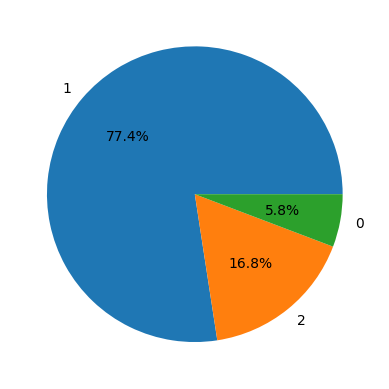

In [31]:
# class 0 - non offensive and no hate speech
# class 1 - offensive
# class 2 - hate speech

plt.pie(df['class'].value_counts().values,
		labels = df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()


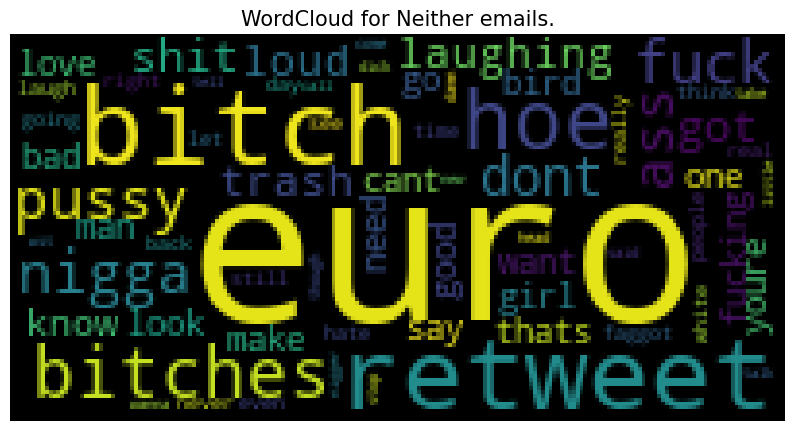

In [32]:
from wordcloud import WordCloud
def plot_word_cloud(data, typ):
# Joining all the tweets to get the corpus
    email_corpus = " ".join(df['tweet'])

    plt.figure(figsize = (10,10))

    # Forming the word cloud
    wc = WordCloud(max_words = 100,
                    width = 200,
                    height = 100,
                    collocations = False).generate(email_corpus)

    # Plotting the wordcloud obtained above
    plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
    print()

plot_word_cloud(df[df['class']==2], typ='Neither')


# Loading the dataset and tokenization

Shape of X_train_pad: (15860, 100)
Shape of y_train_cat: (15860, 2)
Shape of X_val_pad: (3966, 100)
Shape of y_val_cat: (3966, 2)
Shape of X_test_pad: (4957, 100)
Shape of y_test_cat: (4957, 2)


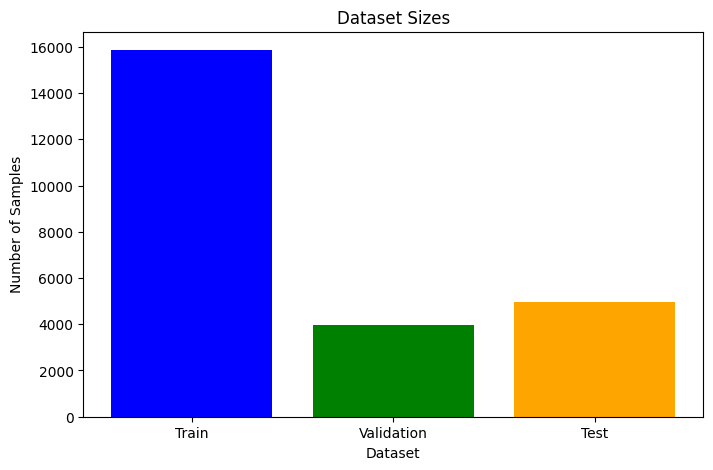

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Load the dataset
df = pd.read_csv('final.csv')
text_column = 'tweet'  # Adjust if the column name is different

# Ensure all entries in the text column are strings
df[text_column] = df[text_column].astype(str).fillna('')

# Map offensive and hate speech to 1 (hate speech), non-offensive to 0 (normal)
label_mapping = {0: 0, 1: 1, 2: 1}
df['label'] = df['class'].map(label_mapping)

# Split the data
X = df[text_column].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ensure all training, validation, and test data are strings
X_train = [str(text) for text in X_train]
X_val = [str(text) for text in X_val]
X_test = [str(text) for text in X_test]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Tokenize the text data
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Verify the shapes of the padded sequences and categorical labels
print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of y_train_cat:", y_train_cat.shape)
print("Shape of X_val_pad:", X_val_pad.shape)
print("Shape of y_val_cat:", y_val_cat.shape)
print("Shape of X_test_pad:", X_test_pad.shape)
print("Shape of y_test_cat:", y_test_cat.shape)

# Plotting bar graph for dataset sizes
datasets = ['Train', 'Validation', 'Test']
sizes = [len(X_train), len(X_val), len(X_test)]

plt.figure(figsize=(8, 5))
plt.bar(datasets, sizes, color=['blue', 'green', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Dataset Sizes')
plt.show()


# Model building and plotting


Shape of X_train_pad: (15860, 100)
Shape of y_train_cat: (15860, 2)
Shape of X_val_pad: (3966, 100)
Shape of y_val_cat: (3966, 2)
Shape of X_test_pad: (4957, 100)
Shape of y_test_cat: (4957, 2)


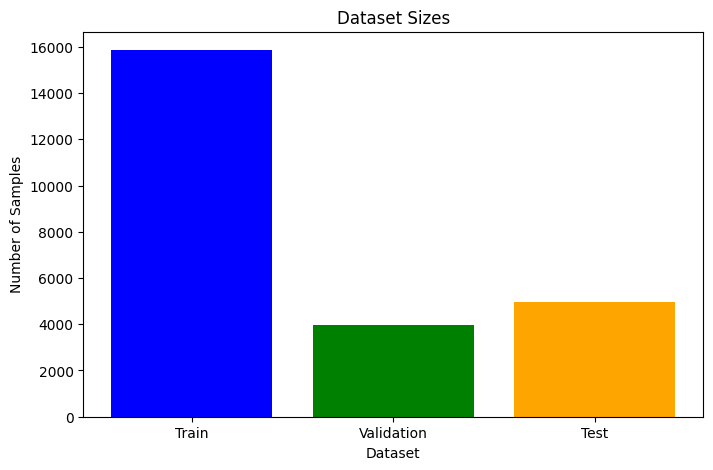

Epoch 1/20


C:\Users\chish\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.9326 - loss: 0.9749 - val_accuracy: 0.9415 - val_loss: 0.2198
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.9436 - loss: 0.2089 - val_accuracy: 0.9415 - val_loss: 0.2041
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.9425 - loss: 0.1860 - val_accuracy: 0.9395 - val_loss: 0.2187
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.9485 - loss: 0.1616 - val_accuracy: 0.9403 - val_loss: 0.1923
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.9515 - loss: 0.1466 - val_accuracy: 0.9373 - val_loss: 0.1988
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.9559 - loss: 0.1326 - val_accuracy: 0.9393 - val_loss: 0.1971
Epoch 7/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.9584 - loss: 0.1264 - val_accuracy: 0.9395 - val_loss: 0.2253
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Accuracy Score: 0.9402864635868469
Classification Report:
 

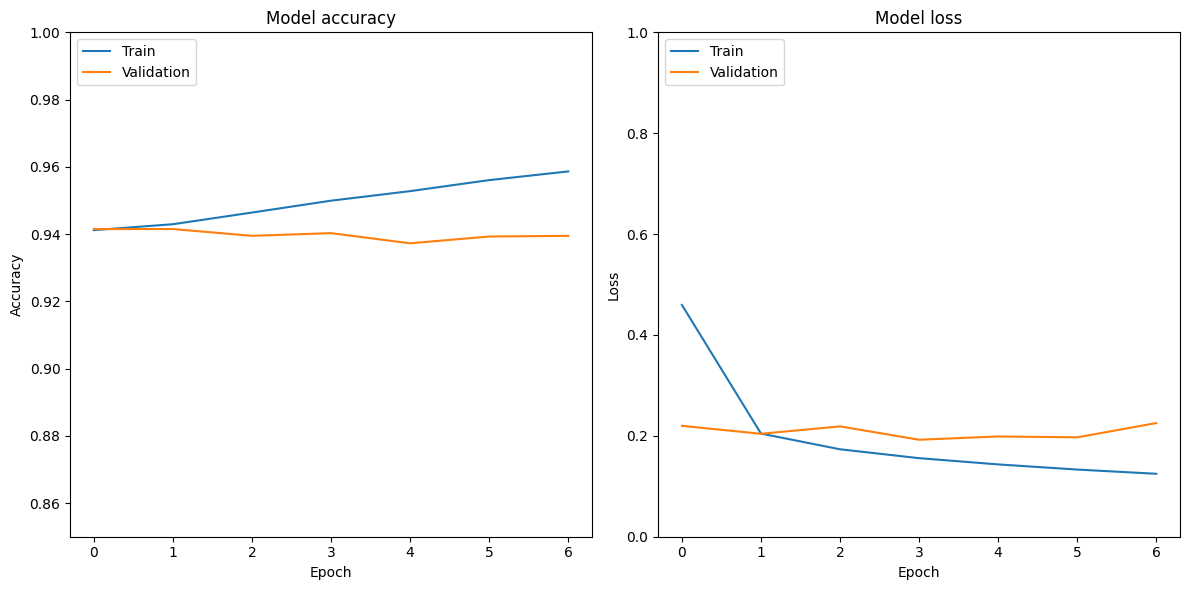

775/775 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  predicted_label  \
0  !!! RT @mayasolovely: As a woman you shouldn't...                1   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...                1   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...                1   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...                1   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...                1   

  predicted_label_name  
0      non_hate_speech  
1      non_hate_speech  
2   

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
from keras.regularizers import l2
from wordcloud import WordCloud
import pickle

# Load the dataset
df = pd.read_csv('final.csv')
text_column = 'tweet'

df[text_column] = df[text_column].astype(str).fillna('')
label_mapping = {0: 0, 1: 1, 2: 1}
df['label'] = df['class'].map(label_mapping)

# Split the data
X = df[text_column].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ensure all training, validation, and test data are strings
X_train = [str(text) for text in X_train]
X_val = [str(text) for text in X_val]
X_test = [str(text) for text in X_test]

# Tokenize the text data
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Verify the shapes of the padded sequences and categorical labels
print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of y_train_cat:", y_train_cat.shape)
print("Shape of X_val_pad:", X_val_pad.shape)
print("Shape of y_val_cat:", y_val_cat.shape)
print("Shape of X_test_pad:", X_test_pad.shape)
print("Shape of y_test_cat:", y_test_cat.shape)

# Plotting bar graph for dataset sizes
datasets = ['Train', 'Validation', 'Test']
sizes = [len(X_train), len(X_val), len(X_test)]

plt.figure(figsize=(8, 5))
plt.bar(datasets, sizes, color=['blue', 'green', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Dataset Sizes')
plt.show()

# Model building and plotting
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01))))
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Implement EarlyStopping with patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat),
                    epochs=20, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
y_pred_cat = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_cat, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(np.argmax(y_test_cat, axis=1), y_pred)
print("Accuracy Score:", accuracy)

# Print classification report
print("Classification Report:\n", classification_report(np.argmax(y_test_cat, axis=1), y_pred))

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0.85, 1.00)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0, 1.00)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the trained model
model.save('trained_model.h5')

# Predictions on new data
new_df = pd.read_csv('labeled_data.csv')
new_df[text_column] = new_df[text_column].astype(str).fillna('')

with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

new_seq = tokenizer.texts_to_sequences(new_df[text_column])
new_pad = pad_sequences(new_seq, maxlen=max_len)

model = load_model('trained_model.h5')
predictions = model.predict(new_pad)
predicted_labels = np.argmax(predictions, axis=1)

new_df['predicted_label'] = predicted_labels
label_mapping = {0: 'hate_speech', 1: 'non_hate_speech'}
new_df['predicted_label_name'] = new_df['predicted_label'].map(label_mapping)

new_df.to_csv('predictions.csv', index=False)
print(new_df.head())


# Predictions

Epoch 1/20


C:\Users\chish\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


620/620 ━━━━━━━━━━━━━━━━━━━━ 78s 109ms/step - accuracy: 0.9085 - loss: 0.5314 - val_accuracy: 0.9413 - val_loss: 0.1910
Epoch 2/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.9511 - loss: 0.1422 - val_accuracy: 0.9415 - val_loss: 0.1855
Epoch 3/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.9621 - loss: 0.1098 - val_accuracy: 0.9387 - val_loss: 0.2019
Epoch 4/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 59s 96ms/step - accuracy: 0.9687 - loss: 0.0930 - val_accuracy: 0.8687 - val_loss: 0.3528
Epoch 5/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 63s 102ms/step - accuracy: 0.9757 - loss: 0.0711 - val_accuracy: 0.9385 - val_loss: 0.2493
Epoch 6/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.9806 - loss: 0.0578 - val_accuracy: 0.9375 - val_loss: 0.2901
Epoch 7/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 76s 123ms/step - accuracy: 0.9811 - loss: 0.0526 - val_accuracy: 0.9278 - val_loss: 0.2827
Epoch 8/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 74s 120ms/step - accuracy: 0.9855 - loss: 0.0420 - val_acc

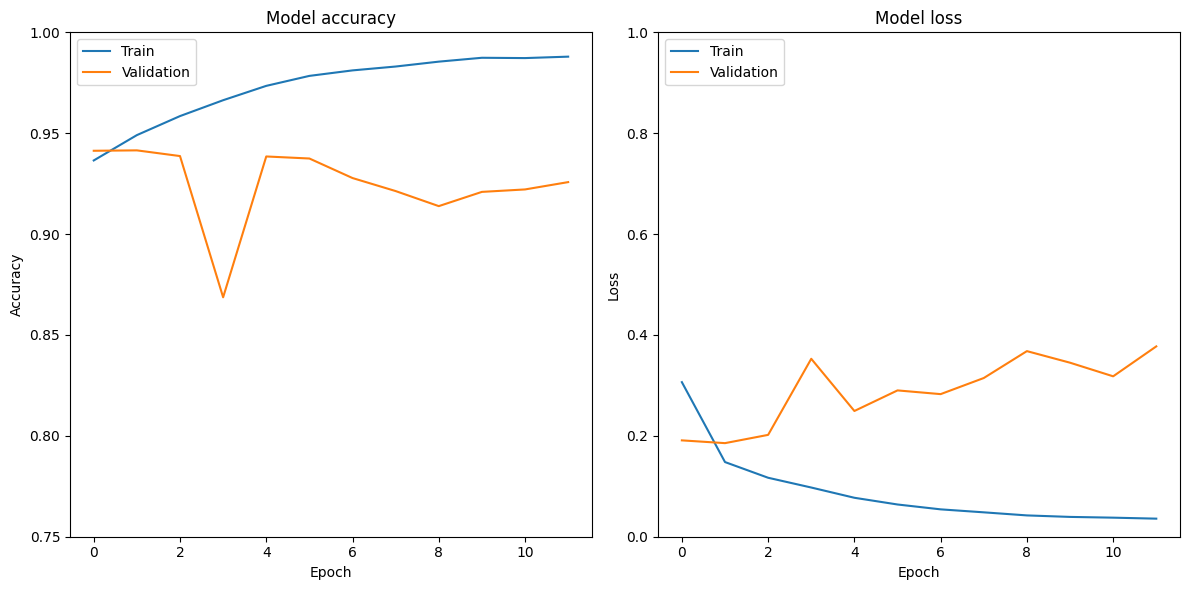

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 128)       │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,246,024 (4.75 MB)

 Trainable params: 415,298 (1.58 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 830,598 (3.17 MB)

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras.preprocessing.text as tf_text
import tensorflow.keras.preprocessing.sequence as tf_seq
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('final.csv')
text_column = 'tweet'  # Adjust if the column name is different

# Ensure all entries in the text column are strings
df[text_column] = df[text_column].astype(str).fillna('')

# Map offensive and hate speech to 1 (hate speech), non-offensive to 0 (normal)
label_mapping = {0: 0, 1: 1, 2: 1}
df['label'] = df['class'].map(label_mapping)

# Split the data
X = df[text_column].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all training and test data are strings
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

# TF-IDF Vectorization (optional, for comparison)
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Tokenize the text data
max_words = 10000
tokenizer = tf_text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = 100
X_train_pad = tf_seq.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = tf_seq.pad_sequences(X_test_seq, maxlen=max_len)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Build the model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),  # Adjust dropout rate
    Dense(2, activation='softmax')
])

# Compile the model with accuracy metric
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Implement EarlyStopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat),
                    epochs=20, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
y_pred_cat = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_cat, axis=1)

# Print evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
print("Evaluation Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0.75, 1.00)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0, 1.00)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Print model summary
model.summary()

# Save the model and make the predictions 

In [16]:
import pickle
from tensorflow.keras.models import Sequential, load_model

# Save the model and tokenizer
model.save('hate_speech_model.h5')  # Save the trained model
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)  # Save the tokenizer
# Example of using the saved model for predictions on new data
# Load the saved model and tokenizer
loaded_model = load_model('hate_speech_model.h5')  # Load the saved model
with open('tokenizer.pkl', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)  # Load the saved tokenizer
# Example of predictions on new data (replace with your own uncleaned dataset)
new_data = pd.read_csv('labeled_data.csv')  # Load new data
text_column = 'tweet'  # Column containing text data

new_texts = new_data[text_column].astype(str).fillna('')  # Clean and preprocess text

new_seq = loaded_tokenizer.texts_to_sequences(new_texts)  # Tokenize text
new_pad = tf_seq.pad_sequences(new_seq, maxlen=max_len)  # Pad sequences

predictions = loaded_model.predict(new_pad)  # Make predictions
predicted_labels = np.argmax(predictions, axis=1)  # Determine predicted labels

# Map labels back to original categories if needed
label_mapping_inverse = {1: 'hate_speech', 0: 'non_hate_speech'}
predicted_labels_names = [label_mapping_inverse[label] for label in predicted_labels]

# Add predictions to the dataframe
new_data['predicted_label'] = predicted_labels_names  # Add predicted labels to DataFrame
new_data.to_csv('predictions.csv', index=False)  # Save predictions to CSV

print(new_data.head())  # Display the first few rows of the DataFrame with predictions
# Print model summary
loaded_model.summary()  # Display a summary of the loaded model


775/775 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet predicted_label  
0  !!! RT @mayasolovely: As a woman you shouldn't...     hate_speech  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...     hate_speech  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...     hate_speech  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...     hate_speech  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...     hate_speech  


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 128)       │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,428 (1.58 MB)

 Trainable params: 415,298 (1.58 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2 (12.00 B)

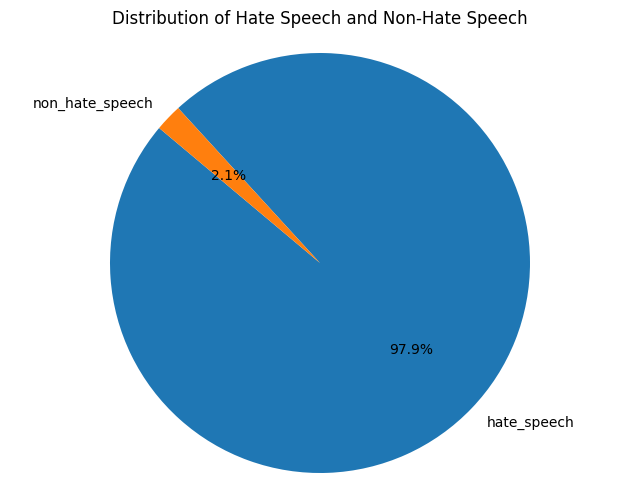

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (assuming 'predictions.csv' as the file containing predictions)
new_data = pd.read_csv('predictions.csv')

# Calculate counts of each label
label_counts = new_data['predicted_label'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Hate Speech and Non-Hate Speech')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
